In [93]:
%load_ext lab_black

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import re
import math
import tensorflow as tf
import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from textblob import Word
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    MinMaxScaler,
    OrdinalEncoder,
)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    AdaBoostClassifier,
    AdaBoostRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    VotingClassifier,
    StackingRegressor,
    StackingClassifier,
    ExtraTreesRegressor,
    ExtraTreesClassifier,
)
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
    HashingVectorizer,
)
from lightgbm import LGBMRegressor, LGBMClassifier
import scipy
from xgboost import XGBRegressor, XGBClassifier
from pprint import pprint
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    RandomForestClassifier,
    GradientBoostingClassifier,
)
from sklearn.kernel_ridge import KernelRidge
from joblib import Parallel, delayed
from tune_sklearn import TuneGridSearchCV
import warnings
from catboost import CatBoostRegressor, CatBoostClassifier
import random
import pycountry
import wordcloud
from nltk import pos_tag, word_tokenize
from sklearn.pipeline import make_pipeline

sns.set_palette("Blues")

PANDAS_DEFAULT_MAX_ROWS_OPTIONS = pd.get_option("display.max_rows")

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [3]:
def lemmatize(content):
    sent = []
    for word, tag in pos_tag(word_tokenize(content.lower())):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ["a", "r", "n", "v"] else None
        if not wntag:
            lemma = word
        else:
            lemma = lematizer.lemmatize(word, wntag)
        sent.append(lemma)
    return " ".join(sent)


train = pd.read_csv("Final_Train_Dataset.csv")
test = pd.read_csv("Final_Test_Dataset.csv")
lematizer = WordNetLemmatizer()
train["istrain"] = 1
train.rename(columns={"Unnamed: 0": "indexing"}, inplace=True)
test["istrain"] = 0
# train.drop(["Unnamed: 0"], axis=1, inplace=True)
# train["duplicate_keys"] = (
#     train["job_description"]
#     + " "
#     + train.job_desig
#     + " "
#     + train.key_skills
#     + " "
#     + train.location
# )
# train["duplicate_keys"] = train.duplicate_keys.str.lower()
# print("train", len(train))
# train.drop_duplicates(inplace=True, subset="duplicate_keys")
# print("train after", len(train))
# train.drop("duplicate_keys", inplace=True, axis=1)
traintest = pd.concat([train, test], axis=0).reset_index()

stop = stopwords.words("english")
traintest["experience_min"] = traintest.experience.str.extract("^(\d+)-").astype(
    np.float32
)
traintest["experience_max"] = traintest.experience.str.extract(".*-(\d+).*").astype(
    np.float32
)
traintest["is_jobtype_exists"] = traintest.job_type.notnull().astype(int)
traintest.drop("job_type", axis=1, inplace=True)
traintest["num_locations"] = traintest.location.apply(
    lambda x: max(len(x.split(",")), len(x.split("|")), len(x.split("/")))
)
traintest["num_positions"] = traintest.job_desig.apply(
    lambda x: max(len(x.split(",")), len(x.split("|")), len(x.split("/")))
)
traintest["has_special_location"] = traintest.location.str.contains("\(").astype(int)
traintest["is_desc_exists"] = (traintest.job_description.notnull()).astype(int)
# create a new column for all text fields, fillna for other columns
for col in ["key_skills", "job_desig", "job_description"]:
    traintest[col] = traintest[col].fillna("")
traintest["job_info"] = traintest[["job_desig", "job_description", "key_skills"]].agg(
    " ".join, axis=1
)
for col in ["key_skills", "job_desig", "job_description", "job_info"]:
    traintest[col] = traintest[col].str.lower()
    traintest[col] = traintest[col].str.replace("[^\w ]", " ").fillna("")
    #     traintest[col] = traintest[col].str.replace(" sr ", " senior")
    traintest[col] = traintest[col].apply(
        lambda x: " ".join(i for i in x.split() if i not in stop)
    )
    traintest[col] = traintest[col].apply(lemmatize)


traintest["company"] = traintest["company_name_encoded"].astype(str)
traintest["company_size"] = traintest.company  # estimate how big a company is
traintest["company_size"] = traintest.company_size.map(
    traintest.company_size.value_counts()
)
traintest["is_senior"] = (traintest.experience_min >= 5).astype(int)

traintest["is_senior_position"] = traintest.job_info.apply(
    lambda x: any(
        [
            i
            for i in x.split()
            if i
            in [
                "senior",
                "head",
                "manage",
                "lead",
                "vp",
                "director",
                "deputy",
                "leadership",
                "president",
                "chief",
                "sr",
            ]
        ]
    )
).astype(int)


traintest["exp_range"] = (traintest.experience_max - traintest.experience_min).astype(
    int
)
traintest["desc_len"] = traintest.job_info.apply(lambda x: len(x))
traintest["skill_len"] = traintest.key_skills.apply(lambda x: len(x))
traintest["salary_num"] = traintest.salary.replace(
    ["0to3", "3to6", "6to10", "10to15", "15to25", "25to50"], [1, 2, 3, 4, 5, 6]
)
traintest["num_locations"] = traintest.location.apply(lambda x: len(x.split(",")))

traintest["location_simple"] = traintest.location.str.lower()
traintest["location_simple"] = traintest.location_simple.str.replace("[^\w ]+", " ")
all_locations = " ".join(traintest.location_simple).split()
location_freq = {k: all_locations.count(k) for k in set(all_locations)}
traintest["location_popularity"] = traintest.location_simple.apply(
    lambda x: max(location_freq.get(i.strip(), 0) for i in x.split())
)
traintest["is_junior"] = traintest.job_info.apply(
    lambda x: any(
        i
        for i in [
            "entry",
            "part time",
            "fresh",
            "graduate",
            "intern",
            "student",
            "outsourc",
            "offic",
        ]
        if i in x
    )
).astype(int)


all_countries = list(c.name.lower() for c in list(pycountry.countries)) + [
    "uae",
    "u.k",
    "anywhere",
    "other",
    "anywhere",
    "dallas",
    "japan",
    "yangon",
    "california",
    "angeles",
    "kuwait",
    "united",
    "dubai",
    "york",
    "kingdom",
    "kong",
    "uk",
    "africa",
]
traintest["is_abroad"] = traintest.location_simple.apply(
    lambda x: any(i for i in x.split() if i in all_countries)
).astype(int)

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: The default value of regex will change from True to False in a future version.
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:112: FutureWarning: The default value of regex will change from True to False in a future version.


In [181]:
traintest.key_skills.str.len().value_counts()

64    1686
66    1512
62    1464
65    1456
63    1440
      ... 
73       8
6        8
5        4
2        3
4        1
Name: key_skills, Length: 73, dtype: int64

In [4]:
from collections import defaultdict

traintest["num_repeating_job_desc"] = 0
traintest["num_repeating_job_desc_desig"] = 0
traintest["num_repeating_job_desc_desig_skills"] = 0
job_desc_repeating = defaultdict(int)
job_desc_desig_repeating = defaultdict(int)
job_desc_desig_skills_repeating = defaultdict(int)
for i, row in traintest.iterrows():
    key = " ".join([row["job_description"], str(row["company_name_encoded"])])

    traintest.at[i, "num_repeating_job_desc"] = job_desc_repeating[key]
    job_desc_repeating[key] += 1

    key = " ".join(
        [row["job_description"], row["job_desig"], str(row["company_name_encoded"])]
    )
    traintest.at[i, "num_repeating_job_desc_desig"] = job_desc_desig_repeating[key]
    job_desc_desig_repeating[key] += 1

    key = " ".join(
        [
            row["job_description"],
            row["job_desig"],
            row["key_skills"],
            str(row["company_name_encoded"]),
        ]
    )
    traintest.at[
        i, "num_repeating_job_desc_desig_skills"
    ] = job_desc_desig_skills_repeating[key]
    job_desc_desig_skills_repeating[key] += 1

<AxesSubplot:>

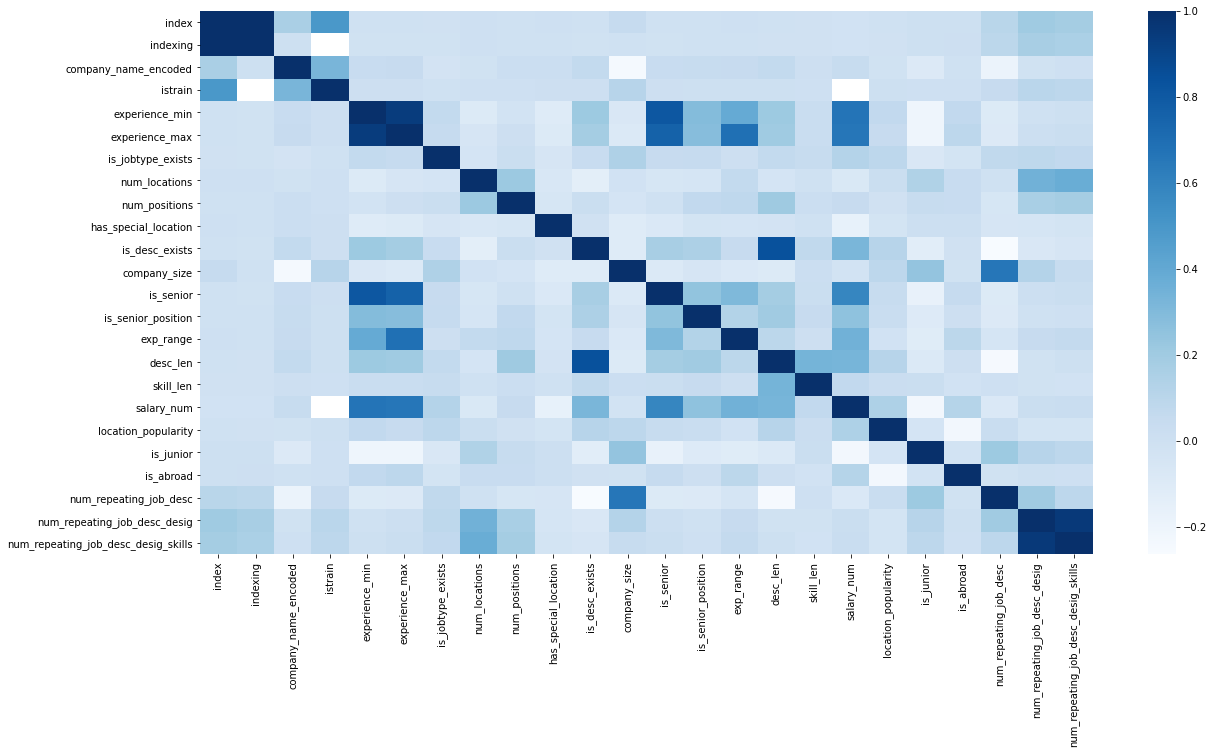

In [5]:
plt.figure(figsize=(20, 10))
sns.heatmap(traintest.corr(), cmap="Blues")

In [8]:
import random


def split_train_test(traintest, test_ratio=0.2, upsample=False):
    val_indexes = []
    for test_company in test.company_name_encoded.unique():
        indexes = list(
            traintest[
                (traintest.company_name_encoded == test_company)
                & (traintest.istrain == 1)
            ].index
        )
        #         len_test_indexes = len(test[test.company_name_encoded == test_company])
        if len(indexes) == 1:
            val_indexes += indexes
        else:
            num_to_choose = max(1, int(len(indexes) * test_ratio))
            val_indexes += random.sample(indexes, num_to_choose)
    val_indexes = set(val_indexes)
    train_indexes = list(
        set(traintest[traintest.istrain == 1].index).difference(set(val_indexes))
    )

    if upsample:
        value_counts = dict(traintest.iloc[train_indexes].salary.value_counts())
        most_class_count = max(value_counts.values())
        new_train_indexes = []
        for c, count in value_counts.items():
            c_index = list(
                traintest.iloc[train_indexes][
                    traintest.iloc[train_indexes].salary == c
                ].index
            )
            if upsample and count < most_class_count:
                while len(c_index) < most_class_count:
                    c_index *= 2
                c_index = c_index[:most_class_count]
            new_train_indexes += c_index
        return list(new_train_indexes), list(val_indexes)
    else:
        return list(train_indexes), list(val_indexes)


trainval_splits = []
for i in range(5):
    itrain, ival = split_train_test(traintest, test_ratio=0.99, upsample=False)
    print(len(itrain), len(ival))
    trainval_splits.append((itrain, ival))

9931 9871
9931 9871
9931 9871
9931 9871
9931 9871


In [63]:
len(train), len(test)

(19802, 6601)

In [90]:
def index_split(test_size=4000, train_size=3802):
    num_folds = 4
    indexes = []
    offset = 0
    for i in range(num_folds):
        indexes.append(
            (
                range(offset, offset + train_size),
                range(offset + train_size, offset + train_size + test_size),
            )
        )
        offset += test_size
    return indexes


trainval_splits = index_split()

In [91]:
trainval_splits

[(range(0, 3802), range(3802, 7802)),
 (range(4000, 7802), range(7802, 11802)),
 (range(8000, 11802), range(11802, 15802)),
 (range(12000, 15802), range(15802, 19802))]

In [73]:
tree_processor = ColumnTransformer(
    transformers=[
        (
            "passthough",
            FunctionTransformer(lambda x: x),
            [
                "experience_min",
                "experience_max",
                "is_jobtype_exists",
                "exp_range",
                "is_senior",
                "is_junior",
                "desc_len",
                "is_desc_exists",
                "is_senior_position",
                "num_locations",
                "num_positions",
                "has_special_location",
                "company_size",
                "location_popularity",
                "company_name_encoded",
                "num_repeating_job_desc",
                "num_repeating_job_desc_desig",
                "num_repeating_job_desc_desig_skills",
            ],
        ),
    ]
)

tree_pipe = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                [
                    ("numeric", tree_processor),
                    (
                        "job_desig",
                        Pipeline(
                            [
                                (
                                    "selector",
                                    FunctionTransformer(lambda x: x["job_desig"]),
                                ),
                                (
                                    "vectorizer",
                                    CountVectorizer(
                                        stop_words=stop, ngram_range=(1, 2)
                                    ),
                                ),
                            ]
                        ),
                    ),
                ],
            ),
        )
    ],
)

In [40]:
from sklearn.metrics import accuracy_score


def submit(m):
    salary = m.predict(traintestp[len(traintest[traintest.istrain == 1]) :])
    test["salary"] = salary
    test.to_excel("submission.xlsx")


def fit(m):
    m.fit(traintestp[: len(traintest[traintest.istrain == 1])], train.salary)
    return m

In [74]:
mlp_processor = ColumnTransformer(
    transformers=[
        (
            "passthrough",
            FunctionTransformer(lambda x: x),
            [
                "is_jobtype_exists",
                "is_senior",
                "is_junior",
                "is_desc_exists",
                "is_senior_position",
                "has_special_location",
            ],
        ),
        (
            "standard scaler",
            StandardScaler(),
            [
                "experience_min",
                "experience_max",
                "exp_range",
                "desc_len",
                "num_locations",
                "num_positions",
                "company_size",
                "location_popularity",
                "num_repeating_job_desc",
                "num_repeating_job_desc_desig",
                "num_repeating_job_desc_desig_skills",
            ],
        ),
    ]
)
mlp_pipe = Pipeline(
    [
        (
            "union",
            FeatureUnion(
                [
                    ("numeric", mlp_processor),
                    (
                        "job_desig",
                        Pipeline(
                            [
                                (
                                    "selector",
                                    FunctionTransformer(lambda x: x["job_desig"]),
                                ),
                                (
                                    "vectorizer",
                                    CountVectorizer(
                                        stop_words=stop, ngram_range=(1, 2)
                                    ),
                                ),
                            ]
                        ),
                    ),
                    (
                        "key_skills",
                        Pipeline(
                            [
                                (
                                    "selector",
                                    FunctionTransformer(lambda x: x["key_skills"]),
                                ),
                                (
                                    "vectorizer",
                                    TfidfVectorizer(
                                        stop_words=stop, ngram_range=(1, 2)
                                    ),
                                ),
                            ]
                        ),
                    ),
                ],
            ),
        )
    ],
)

In [76]:
adaboost_clf = AdaBoostClassifier()
cv_2(make_pipeline(mlp_pipe, adaboost_clf))

0.4008333333333333 [0.397, 0.4033333333333333, 0.38566666666666666, 0.41733333333333333] taken =  0:00:06.757737


In [92]:
cv_2(make_pipeline(tree_pipe, LGBMClassifier()))

0.44962500000000005 [0.449, 0.448, 0.441, 0.4605] taken =  0:00:04.638643


In [55]:
from sklearn.svm import SVC

cv_2(make_pipeline(mlp_pipe, SVC()))

0.4226724749265525 [0.42356397528112655, 0.42244959983790903, 0.4232600547057036, 0.4245770438658697, 0.4195117009421538] taken =  0:02:55.139857


In [ ]:
mlp_pipeline = make_pipeline(mlp_pipe, AdaBoostClassifier(random_state=42))
cv(traintest[traintest.istrain==1], mlp_pipeline)

In [35]:
cv_2(mlp_pipeline)

[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.1s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.1s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.1s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.1s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.1s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.1s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.1s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.1s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.1s
[Pipel

In [98]:
tree_pipeline = make_pipeline(tree_pipe, LGBMClassifier(random_state=42))


def cv_2(model, n_jobs=-1):
    ts = datetime.now()
    results = []
    for itrain, itest in trainval_splits:
        print(itrain, itest)
        m = clone(model)
        m.fit(traintest[traintest.istrain == 1].iloc[itrain], train.salary.iloc[itrain])
        ypred = m.predict(traintest[traintest.istrain == 1].iloc[itest])
        score = accuracy_score(train.salary.iloc[itest], ypred)
        cm = confusion_matrix(
            train.salary.iloc[itest],
            ypred,
            labels=["0to3", "3to6", "6to10", "10to15", "15to25", "25to50"],
        )
        #         print(cm)
        results.append(score)
    print(np.mean(results), results, f"taken = ", datetime.now() - ts)


cross_validate(
    tree_pipeline,
    traintest[traintest.istrain == 1],
    train.salary,
    scoring="accuracy",
    n_jobs=-1,
)
# cv_2(tree_pipeline)

{'fit_time': array([2.53734398, 2.53471065, 2.54470921, 2.5699141 , 2.55085278]),
 'score_time': array([0.50441074, 0.51112223, 0.51427317, 0.51211286, 0.51021004]),
 'test_score': array([0.4609947 , 0.47235547, 0.47828283, 0.46944444, 0.48484848])}

In [96]:
stacking_clf = StackingClassifier(
    estimators=[
        ("lgbm", make_pipeline(tree_pipe, LGBMClassifier())),
        ("mlp", make_pipeline(mlp_pipe, AdaBoostClassifier())),
        ("svc", make_pipeline(mlp_pipe, SVC())),
    ]
)
cv_2(stacking_clf)

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stabl

0.467625 [0.46525, 0.4675, 0.4595, 0.47825] taken =  0:01:51.576327


In [24]:
def rs(m, params):
    random_search = RandomizedSearchCV(
        m,
        params,
        n_iter=500,
        scoring=sklearn.metrics.accuracy_score,
        n_jobs=-1,
        cv=trainval_splits,
        verbose=4,
    )
    random_search.fit(
        traintestp[: len(traintest[traintest.istrain == 1])],
        train.salary,
    )
    return random_search

In [ ]:
lgbm_params = {
    "num_leaves": list(range(10, 50, 2)) + [None],
    "min_child_samples": list(range(100, 500, 100)) + [None],
    "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, None],
    "subsample": [0.2, 0.4, 0.6, 0.8, 1, None],
    "reg_alpha": [0, 1e-1, 1, 2, 5, 7, 10, 50, 100, None],
    "reg_lambda": [0, 1e-1, 1, 5, 10, 20, 50, 100, None],
}
lgbm_model = LGBMClassifier()
lgbm_search = rs(lgbm_model, params=lgbm_params)
lgbm_search

In [39]:
stacking_clf.fit(traintest[traintest.istrain==1], train.salary)
submit(stacking_clf)

[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.2s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.2s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.2s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.2s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.2s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.2s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.2s
[Pipeline] ............. (step 1 of 1) Processing union, total=   0.2s
[FeatureUnion] ....... (step 1 of 2) Processing numeric, total=   0.0s
[FeatureUnion] ..... (step 2 of 2) Processing job_desig, total=   0.2s
[Pipel

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


NameError: name 'submit' is not defined

In [43]:
salary = stacking_clf.predict(traintest[traintest.istrain == 0])
test["salary"] = salary
test.to_excel("submission.xlsx")